# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.07

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220402-P_brain_CTP11-13_from_0329'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'

save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp'

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

40884


## 0.1 Folders

In [2]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0709')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

161 fovs detected
Use segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Segmentation
Use cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\CandSpots
Use decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder
Use picked_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Picked_v0


In [3]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Decoding of DNA-MERFISH

In [4]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
ctp13_codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,1:9600471-9656458,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:9749317-9845402,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,1:20888605-20953251,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
3,1:21475446-21564433,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,1:21674557-21793163,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,X:101910335-102015609,987,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,X,2
964,X:136772307-136851006,988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,3
965,X:140481839-140547985,989,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,4
966,X:167122110-167191320,990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,5


## Load bit_2_name

In [5]:
readout_df_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_combo_readouts.csv')
readout_df_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mouse-SE_combo_readouts.csv')

# merge
readout_df_se['Bit']+=100
readout_df = pd.concat([readout_df_gn, readout_df_se])
readout_df

,Bit,ReadoutName
0,1,NDB_784
1,2,NDB_755
2,3,NDB_826
3,4,NDB_713
4,5,NDB_865
...,...,...
90,191,NDB_592
91,192,NDB_368
92,193,NDB_436
93,194,NDB_629


## 3.3 prepare kwargs to decode CTP11

In [6]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp11_data_type = 'combo'
ctp11_lib_name = 'CTP11'
ctp11_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp11_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp11_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp11_decode_args.append(
            (ctp11_lib_name, _cell_spots_df, ctp11_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp11_decode_args))

- Preparing decoding args for fov: 0, 135
- Preparing decoding args for fov: 1, 253
- Preparing decoding args for fov: 2, 401
- Preparing decoding args for fov: 3, 546
- Preparing decoding args for fov: 4, 692
- Preparing decoding args for fov: 5, 840
- Preparing decoding args for fov: 6, 986
- Preparing decoding args for fov: 7, 1126
- Preparing decoding args for fov: 8, 1280
- Preparing decoding args for fov: 9, 1442
- Preparing decoding args for fov: 10, 1614
- Preparing decoding args for fov: 11, 1768
- Preparing decoding args for fov: 12, 1918
- Preparing decoding args for fov: 13, 2071
- Preparing decoding args for fov: 14, 2188
- Preparing decoding args for fov: 15, 2325
- Preparing decoding args for fov: 16, 2465
- Preparing decoding args for fov: 17, 2579
- Preparing decoding args for fov: 18, 2708
- Preparing decoding args for fov: 19, 2819
- Preparing decoding args for fov: 20, 2956
- Preparing decoding args for fov: 21, 3074
- Preparing decoding args for fov: 22, 3200
- Pre

## Test decoding for one cell

In [10]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 10

# conbinatorial
batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
#batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12.hdf5
-- savefile:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12.hdf5 not exist, skip
- Matching 194 bits to (988, 103) codebook
-- 99 bits matched
- Process (988, 102) codebook into valid pairs
-- 2964 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- filter candidate pairs by codebook
-- 16246 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|██████████████████████████████████████████████████████████████████████████| 16246/16246 [00:02<00:00, 5689.10it/s]


-- 1432 full tuples selected


100%|████████████████████████████████████████████████████████████████████████| 16246/16246 [00:00<00:00, 103199.18it/s]


-- 1547 pairs selected
-- in total 2979 spot_groups detected
- Save decoder of CTP11 into file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  pytables.to_hdf(


- Save spot_stats iamage to file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12_CTP11_stats.png


## Plot decoded spots

In [7]:
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')

matplotlib.rcParams['pdf.fonttype'] = 42

In [8]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D_figures')
print(decoded_figure_folder)
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_3D_figures


<IPython.core.display.Javascript object>


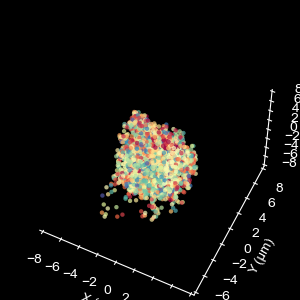

In [11]:
%matplotlib notebook
sel_lib = 'CTP11'
_decoded_groups = pd.read_hdf(ctp11_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

# Process All

In [12]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp11_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp11_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

19289
Wall time: 2h 36s


In [13]:
# Delete args to release RAM
del(ctp11_decode_args)
del(decode_results)

## 3.4 prepare kwargs to decode CTP13

In [14]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp13_data_type = 'combo'
ctp13_lib_name = 'CTP13'
ctp13_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp13_lib_name in _f.keys():
                    continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            (ctp13_lib_name, _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp13_decode_args))

- Preparing decoding args for fov: 0, 135
- Preparing decoding args for fov: 1, 253
- Preparing decoding args for fov: 2, 401
- Preparing decoding args for fov: 3, 546
- Preparing decoding args for fov: 4, 692
- Preparing decoding args for fov: 5, 840
- Preparing decoding args for fov: 6, 986
- Preparing decoding args for fov: 7, 1126
- Preparing decoding args for fov: 8, 1280
- Preparing decoding args for fov: 9, 1442
- Preparing decoding args for fov: 10, 1614
- Preparing decoding args for fov: 11, 1768
- Preparing decoding args for fov: 12, 1918
- Preparing decoding args for fov: 13, 2071
- Preparing decoding args for fov: 14, 2188
- Preparing decoding args for fov: 15, 2325
- Preparing decoding args for fov: 16, 2465
- Preparing decoding args for fov: 17, 2579
- Preparing decoding args for fov: 18, 2708
- Preparing decoding args for fov: 19, 2819
- Preparing decoding args for fov: 20, 2956
- Preparing decoding args for fov: 21, 3074
- Preparing decoding args for fov: 22, 3200
- Pre

## Test decoding the same cell

In [15]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder

# conbinatorial
#batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
#batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12.hdf5
-- savefile:\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12.hdf5 doesn't have information for CTP13, skip
- Matching 194 bits to (968, 99) codebook
-- 95 bits matched
- Process (968, 98) codebook into valid pairs
-- 2904 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 14999 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|██████████████████████████████████████████████████████████████████████████| 14999/14999 [00:02<00:00, 5706.35it/s]


-- 1268 full tuples selected


100%|████████████████████████████████████████████████████████████████████████| 14999/14999 [00:00<00:00, 127594.03it/s]


-- 1502 pairs selected
-- in total 2770 spot_groups detected
- Save decoder of CTP13 into file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups
- Save spot_stats iamage to file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Decoder\Decoded_fov-0_cell-12_CTP13_stats.png


<IPython.core.display.Javascript object>


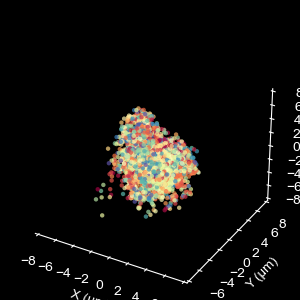

In [16]:
%matplotlib notebook
sel_lib = 'CTP13'
_decoded_groups = pd.read_hdf(ctp13_decode_args[sel_cell][4], f'{sel_lib}/spotGroups')
_zxys = _decoded_groups[['center_z', 'center_x', 'center_y']].values / 1000
_zxys = _zxys - np.nanmean(_zxys, axis=0)
_rids = _decoded_groups['region_id'].values

figure_width = 3
figure_dpi=100
marker_size = 10
marker_alpha = 0.7
_font_size = 7.5
plot_radius = 8
background_color = [0,0,0]
depthshade=False

fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)

ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

_valid_inds = (np.isnan(_zxys).sum(1) == 0)
_sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                   c=_rids, cmap='Spectral',
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   linewidth=0,)
# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)

# save pdf and png
fig.savefig(os.path.join(decoded_figure_folder, 
                         f"{os.path.basename(ctp13_decode_args[sel_cell][4]).replace('.hdf5', f'_decoded_{sel_lib}.png')}"),
            transparent=True)

## Process ALL

In [17]:
%%time
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder
import multiprocessing as mp
print(len(ctp13_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp13_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

19289
Wall time: 1h 55min 32s


In [18]:
# Delete args to release RAM
del(ctp13_decode_args)
del(decode_results)

# 5. CTP12, sequential TSS for markergenes

## 5.1 prepare kwargs to map sequential CTP12

In [19]:
ctp12_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_sequential-codebook.csv', header=0)
ctp12_codebook

,name,id,chr,Stv_91,Stv_32,Stv_92,Stv_33,Stv_94,Stv_35,Stv_95,...,Stv_106,Stv_45,Stv_107,Stv_46,Stv_109,Stv_48,Stv_118,Stv_50,Stv_119,Stv_53
0,5:31098237-31118237,Slc30a3,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7:45153949-45173949,Slc17a7,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2:158600767-158620767,Slc32a1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2:70543072-70563072,Gad1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5:30451932-30471932,Otof,5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4:124976430-124996430,Rspo1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,15:78196400-78216400,Pvalb,15,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,16:23880958-23900958,Sst,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,10:5629218-5649218,Vip,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14:34364789-34384789,Sncg,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
ctp12_readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_unique_readouts.csv', header=0)
ctp12_readout_df

,Bit,ReadoutName
0,1,Stv_91
1,2,Stv_32
2,3,Stv_92
3,4,Stv_33
4,5,Stv_94
5,6,Stv_35
6,7,Stv_95
7,8,Stv_36
8,9,Stv_99
9,10,Stv_37


In [21]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

ctp12_lib_name = 'CTP12tss'
ctp12_data_type = 'unique'
ctp12_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id},", end=' ')
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        print(f"-- skip")
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # check if overwrite:
        if not overwrite_decoder and os.path.exists(_decoder_filename):
            # skip if exists
            with h5py.File(_decoder_filename, 'r') as _f:
                if ctp12_lib_name in _f.keys():
                    continue

        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp12_decode_args.append(
            (ctp12_lib_name, _cell_spots_df, ctp12_codebook, ctp12_readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    print(len(ctp12_decode_args))

- Preparing decoding args for fov: 0, 134
- Preparing decoding args for fov: 1, 250
- Preparing decoding args for fov: 2, 395
- Preparing decoding args for fov: 3, 536
- Preparing decoding args for fov: 4, 681
- Preparing decoding args for fov: 5, 829
- Preparing decoding args for fov: 6, 973
- Preparing decoding args for fov: 7, 1111
- Preparing decoding args for fov: 8, 1261
- Preparing decoding args for fov: 9, 1421
- Preparing decoding args for fov: 10, 1591
- Preparing decoding args for fov: 11, 1744
- Preparing decoding args for fov: 12, 1894
- Preparing decoding args for fov: 13, 2046
- Preparing decoding args for fov: 14, 2163
- Preparing decoding args for fov: 15, 2299
- Preparing decoding args for fov: 16, 2437
- Preparing decoding args for fov: 17, 2550
- Preparing decoding args for fov: 18, 2674
- Preparing decoding args for fov: 19, 2782
- Preparing decoding args for fov: 20, 2915
- Preparing decoding args for fov: 21, 3032
- Preparing decoding args for fov: 22, 3155
- Pre

## Process ALL

In [22]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

In [23]:
%%time
print(len(ctp12_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotMapper, ctp12_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

18730
Wall time: 18min 6s


## load decoded results

In [24]:
sel_col = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']

sel_filename = ctp12_decode_args[sel_cell][4]

ctp11_decoded_df = pd.read_hdf(sel_filename, 'CTP11/spotGroups')[sel_col]
ctp13_decoded_df = pd.read_hdf(sel_filename, 'CTP13/spotGroups')[sel_col]

ctp12_decoded_df = pd.read_hdf(sel_filename, 'CTP12tss/candSpots')[sel_col]

## 3D rendering of decoded spots

In [25]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D')
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

In [26]:
from matplotlib import animation
plot_animation = True
angle = 3

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
figure_width = _double_col_width
figure_dpi=100
background_color = [0,0,0]
marker_size = 8
marker_alpha = 1

depthshade=False

<IPython.core.display.Javascript object>


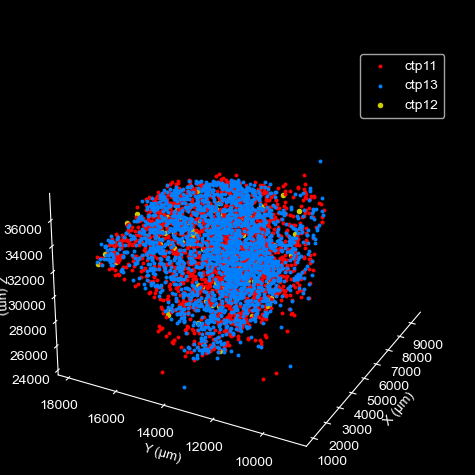

In [27]:
%matplotlib notebook
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')
fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

#"ctp11"
_sc = ax3d.scatter(ctp11_decoded_df['center_z'], ctp11_decoded_df['center_x'], ctp11_decoded_df['center_y'], 
                   color=[1,0,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp11')
#"ctp13"
_sc = ax3d.scatter(ctp13_decoded_df['center_z'], ctp13_decoded_df['center_x'], ctp13_decoded_df['center_y'], 
                   color=[0,0.5,1,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp13')
#"ctp12"
_sc = ax3d.scatter(ctp12_decoded_df['center_z'], ctp12_decoded_df['center_x'], ctp12_decoded_df['center_y'], 
                   color=[0.8,0.8,0,1], 
                   s=marker_size*2, depthshade=depthshade, 
                   alpha=1,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp12')
ax3d.legend()

# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, f"3D_{os.path.basename(sel_filename).replace('.hdf5','.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
fig.show()